In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from scipy import stats
from statsmodels.stats.stattools import durbin_watson

In [34]:
def open_dataset(file_path: str) -> pd.DataFrame:
    try:
        df = pd.read_csv(file_path)
    except Exception as e:
        print(f"An error occurred: open_dataset: {e}")
        return None
    return df

In [35]:
csv_path = 'data.csv'

df = open_dataset(csv_path)

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   km      24 non-null     int64
 1   price   24 non-null     int64
dtypes: int64(2)
memory usage: 512.0 bytes


In [37]:
df.isna().sum()

km       0
price    0
dtype: int64

**Linear regression model assumptions:**

1. Linearity
2. Independence of errors
3. Homoscedasticity
4. Normality of residuals

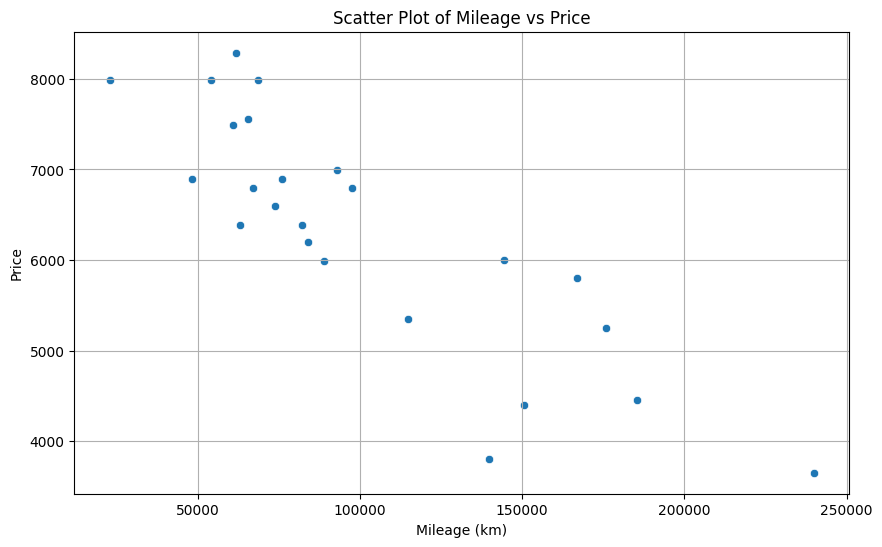

In [38]:
def plot_dataset(df):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='km', y='price', data=df)
    plt.title('Scatter Plot of Mileage vs Price')
    plt.xlabel('Mileage (km)')
    plt.ylabel('Price')
    plt.grid()
    plt.show()

plot_dataset(df)

**Assumption: Linearity**

[Scatter Plot](https://byjus.com/maths/scatter-plot/)

The scatterplot shows a negative linear relationship between mileage and price.<br>The dataset aligns well with the linear regression **assumption of linearity**.

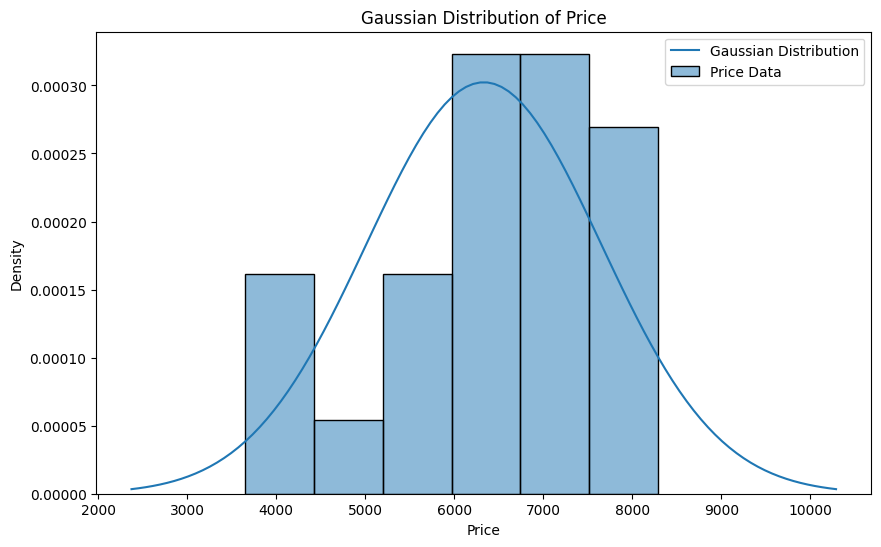

In [39]:
def plot_gaussian_distribution(df):
    mean_price = df['price'].mean()
    std_price = df['price'].std()

    x = np.linspace(mean_price - 3 * std_price, mean_price + 3 * std_price, 100)

    pdf = (1 / (std_price * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean_price) / std_price)**2)

    plt.figure(figsize=(10, 6))

    sns.lineplot(x=x, y=pdf, label='Gaussian Distribution')

    sns.histplot(df['price'], stat='density', kde=False, alpha=0.5, label='Price Data')

    plt.title('Gaussian Distribution of Price')
    plt.xlabel('Price')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

plot_gaussian_distribution(df)

**[Guassian distribution](https://www.datacamp.com/tutorial/gaussian-distribution) histogram provides several insights:**

* the price is approximately normally distributed, but not perfect
* the central tendency of the data is around 6000-7000, but with slight asymmetry in the bars compared to the Gaussian curve which might suggest a mild skew in the data
* the data dispersion is moderate with the clear range
* the gap around 5000 highlights underrepresentation in the approximate interval 4400-5200

**[Z-score](https://www.geeksforgeeks.org/z-score-normalization-definition-and-examples/) [normalization (standardization)](https://www.datacamp.com/tutorial/normalization-in-machine-learning) formula:** $X_{standardized} = \frac{X-\mu}{\sigma}$
<br>$\mu$ - the mean
<br>$\sigma$ - the standard deviation

* ***The standard deviation formula:*** $\sigma = \sqrt{\frac{\sum_{i=1}^n(x_i-\mu)^2}{N}}$

In [40]:
# Z-score scaler

class ZScoreScaler:
    def __init__(self, mean=None, std=None):
        self.mean = mean
        self.std = std

    def fit(self, feature: pd.Series):
        self.mean = feature.mean()
        self.std = feature.std()
        if self.std == 0:
            raise ValueError("Standard deviation is zero. Cannot standardize.")

    def standardize(self, feature: pd.Series) -> pd.Series:
        if self.mean is None or self.std is None:
            raise ValueError("Scaler has not been fitted yet.")
        return (feature - self.mean) / self.std

    def save_scaler(self, file_path: str):
        model = {'mean': self.mean, 'std': self.std}
        with open(file_path, 'w') as file:
            json.dump(model, file)

    def load_scaler(self, file_path: str):
        with open(file_path, 'r') as file:
            scales = json.load(file)
        self.mean = scales.get('mean')
        self.std = scales.get('std')

    def standardize_input(self, value: float) -> float:
        if self.mean is None or self.std is None:
            raise ValueError("Scaler has not been fitted yet.")
        return (value - self.mean) / self.std

In [41]:
scaler_path = 'mileage_scaler.json'

try:
    scaler = ZScoreScaler()
    scaler.fit(df['km'])
    scaler.save_scaler(scaler_path)
    df['km'] = scaler.standardize(df['km'])
except ValueError as e:
    print(f'Error: {e}')

**[Linear regression](https://www.datacamp.com/tutorial/simple-linear-regression) formula:**
* $\hat{y} = wx + b$,<br>
 * $\hat{y}$ - predicted value
 * $w$ - weight
 * $b$ - bias

**Derivatives:**<br>
* with respect to $w$: $\frac{\partial f}{\partial w} = \frac{\partial f}{\partial \hat{y}}\cdot x$
* with respect to $b$: $\frac{\partial f}{\partial b} = \frac{\partial f}{\partial \hat{y}}$

**[Gradient Decent](https://www.datacamp.com/tutorial/tutorial-gradient-descent):**
* $w = \alpha \cdot \frac{\partial f}{\partial w}$
* $b = \alpha \cdot \frac{\partial f}{\partial b}$
 * $\alpha$ - learning rate

**[MSE](https://byjus.com/maths/mean-squared-error/)** **([Mean Square Error](https://dev.to/mondal_sabbha/understanding-mae-mse-and-rmse-key-metrics-in-machine-learning-4la2)):**

* ***Formula:*** $MSE = \frac{1}{N}\sum_{i=1}^n(y_i-\hat{y_i})^2$
* ***Partial derivative with respct to $w$:*** $\frac{\partial MSE}{\partial w}​ = -\frac{2}{N}\sum_{i=1}^n​(y_i-\hat{y_i}​)\cdot x_i$
* ***Partial derivative with respect to $b$:*** $\frac{\partial MSE}{\partial b} = -\frac{2}{N}\sum_{i=1}^n(y_i-\hat{y_i})$

 * *In gradient descent, the constant factor '2' is absorbed into the learning rate $\alpha$, simplifying the update rules:*
 * $w := w-\alpha\cdot \frac{\partial f}{\partial w} := w-\frac{\alpha}{N}\sum_{i=1}^n​(y_i-\hat{y_i}​)\cdot x_i$
 * $b := b-\alpha \cdot \frac{\partial f}{\partial b} := b-\frac{\alpha}{N}\sum_{i=1}^n(y_i-\hat{y_i})$

[Article by Sebastian Raschka, PhD](https://sebastianraschka.com/faq/docs/mse-derivative.html)

In [42]:
# Linear Regression with Gradient Decent and MSE as loss function

class MySimpleLinearRegression:
    def __init__(self, lr=0.001, n_iters=1000):
        self.lr = lr
        self.n_iters = n_iters
        self.theta0 = 0
        self.theta1 = 0

    def estimate_price(self, km):
        return (self.theta0 + (self.theta1 * km))

    def train(self, df):
        m = df['km'].size
        for _ in range(self.n_iters):
            self.theta1 -= (self.lr / m) * np.sum((self.estimate_price(df['km']) - df['price']) * df['km'])
            self.theta0 -= (self.lr / m) * np.sum(self.estimate_price(df['km']) - df['price'])

    def save_model(self, file_path):
        model = {
            'theta0': self.theta0,
            'theta1': self.theta1
        }
        with open(file_path, 'w') as file:
            json.dump(model, file)

In [43]:
lr = MySimpleLinearRegression(lr=0.01, n_iters=600)
lr.train(df)
preds = lr.estimate_price(df['km'])

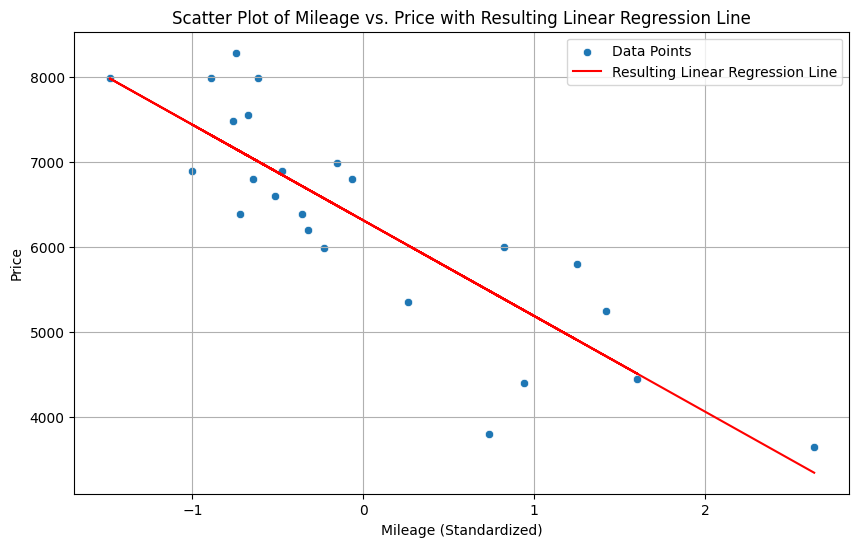

In [44]:
def plot_result(df, preds):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='km', y='price', data=df, label='Data Points')
    plt.plot(df['km'], preds, color='red', label='Resulting Linear Regression Line')
    plt.title('Scatter Plot of Mileage vs. Price with Resulting Linear Regression Line')
    plt.xlabel('Mileage (Standardized)')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()
    plt.show()

plot_result(df, preds)

In [45]:
model_path = 'thetas.json'

In [46]:
lr.save_model(model_path)

In [47]:
def load_model(model_path):
    with open(model_path, 'r') as file:
        model = json.load(file)
    return model

In [48]:
def predict_price(model : dict, km : int) -> int:
    return int(model['theta0'] + (model['theta1'] * km))

In [49]:
def main(km=0):
    try:
        model_path = 'thetas.json'
        model = load_model(model_path)
        scaler_path = 'mileage_scaler.json'
        scaler = ZScoreScaler()
        scaler.load_scaler(scaler_path)
        # km = int(input('Enter mileage: '))
        km = scaler.standardize_input(km)
        print(f'Predicted price: {predict_price(model, km)}')
    except Exception as e:
        print(f'Error: {e}')

main(83745)

Predicted price: 6686


**Residual formula:** $e = y - \hat{y}$
* $e$ - residual
* $y$ - observed value
* $\hat{y}$ - predicted value

In [50]:
vector_predict_price = np.vectorize(predict_price)
predicteded_prices = vector_predict_price(load_model(model_path), df['km'])

residuals = df['price'] - predicteded_prices

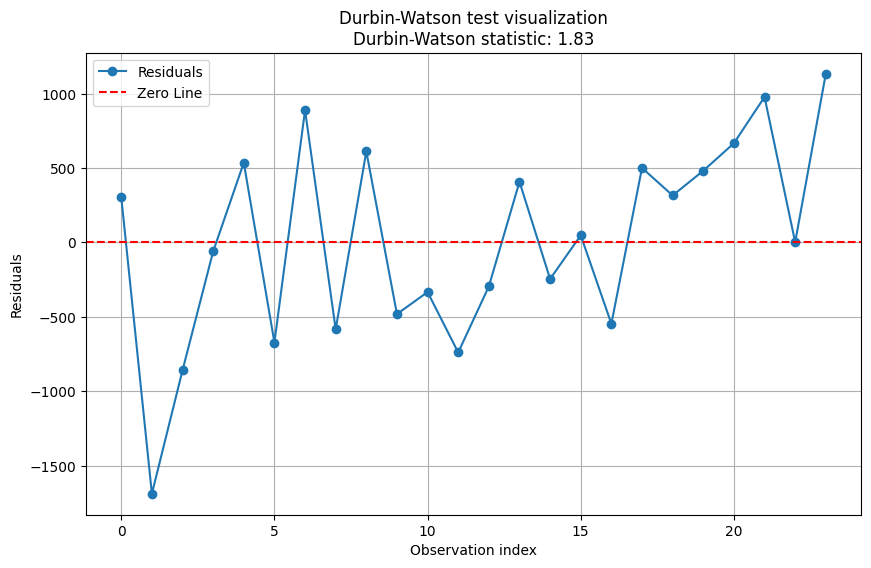

In [51]:
# Visualize residuals and the Durbin-Watson statistic

def durbin_watson_test(residuals):
    # Calculate Durbin-Watson statistic
    dw_stat = durbin_watson(residuals)

    plt.figure(figsize=(10, 6))
    plt.plot(residuals, marker='o', linestyle='-', label='Residuals')
    plt.axhline(0, color='r', linestyle='--', label='Zero Line')
    plt.title(f'Durbin-Watson test visualization\nDurbin-Watson statistic: {dw_stat:.2f}')
    plt.xlabel('Observation index')
    plt.ylabel('Residuals')
    plt.legend()
    plt.grid()
    plt.show()

durbin_watson_test(residuals)

**Assumption: Independence of errors**

[The Durbin-Watson test: definition and examples](https://www.statology.org/durbin-watson-test/)<br>
[Durbin-Watson table](https://www.statology.org/durbin-watson-table/)

According to the table of critical values of DW test and scatterplot where residuals are randomly scattered around zero without a visible pattern, in the dataset is no significant autocorrelation, which indicates that the independence of errors assumption is likely satisfied

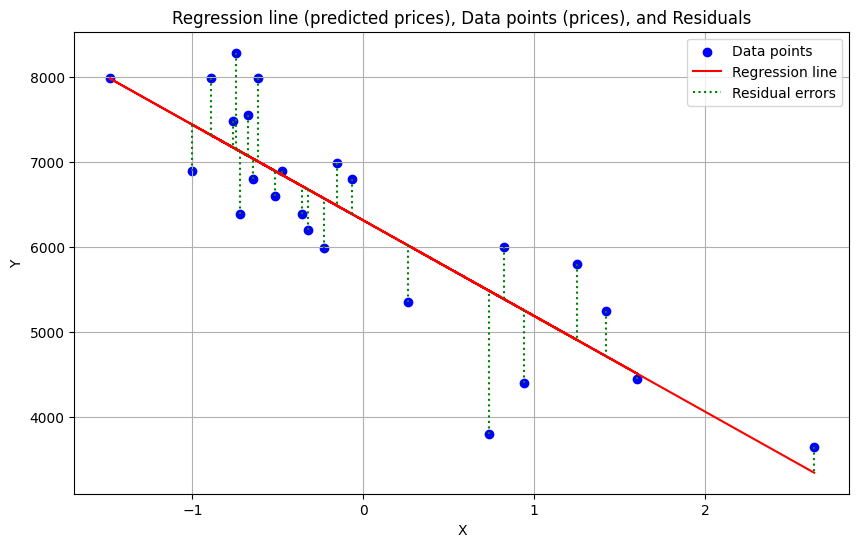

In [52]:
# Visualize the residuals plot

def residuals_plot(residuals):
    plt.figure(figsize=(10, 6))
    plt.scatter(df['km'], df['price'], color='blue', label='Data points')
    plt.plot(df['km'], predicteded_prices, color='red', label='Regression line')
    # Residual lines
    i = 0
    plt.plot([df['km'][i], df['km'][i]], [df['price'][i], predicteded_prices[i]], color='green', linestyle='dotted', label='Residual errors')
    for i in range(1, len(df['km'])):
        plt.plot([df['km'][i], df['km'][i]], [df['price'][i], predicteded_prices[i]], color='green', linestyle='dotted')
    plt.title('Regression line (predicted prices), Data points (prices), and Residuals')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.grid()
    plt.show()

residuals_plot(residuals)

In [53]:
ratio_of_variances = np.var(residuals) / np.var(df['price'])

print(f'Ratio of variances: {ratio_of_variances}')

Ratio of variances: 0.26702762529737206


**Assumption: Homoscedasticity**

[Homoscedasticity / Homogeneity of Variance/ Assumption of Equal Variance](https://www.statisticshowto.com/homoscedasticity/)<br>
[Heteroscedasticity: Simple Definition and Examples](https://www.statisticshowto.com/heteroscedasticity-simple-definition-examples/)<br>
[Residual Values (Residuals) in Regression Analysis](https://www.statisticshowto.com/probability-and-statistics/statistics-definitions/residual/)

The ratio of variances is ≈0.26, which assesses the validity of the assumption of homoscedasticity of the data<br>
Visually residuals are randomly distributed around zero with quite a consistent spread with no distinguishable patterns, which indicates that the assumption of homoscedasticity is likely satisfied as well

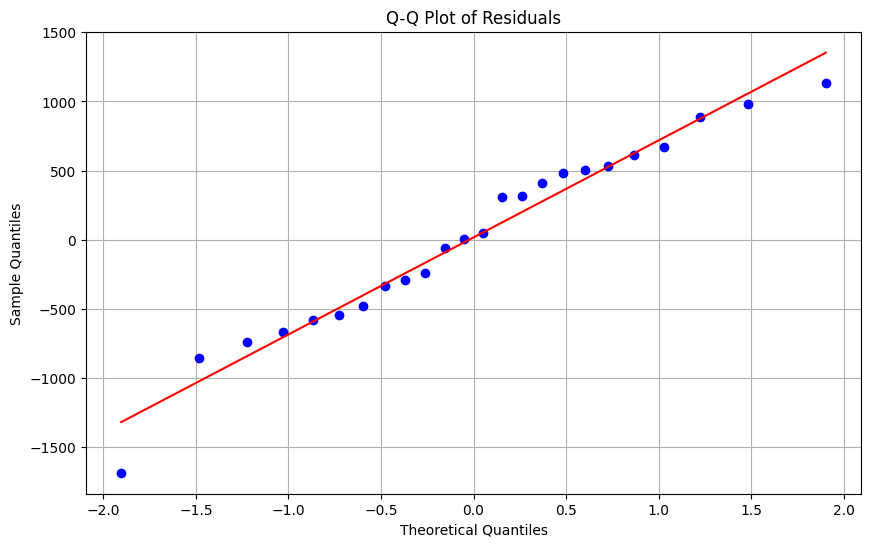

In [54]:
# Visualize Q-Q Plot

def qq_plot(residuals):
    plt.figure(figsize=(10, 6))
    stats.probplot(residuals, dist='norm', plot=plt)
    plt.title('Q-Q Plot of Residuals')
    plt.xlabel('Theoretical Quantiles')
    plt.ylabel('Sample Quantiles')
    plt.grid()
    plt.show()

qq_plot(residuals)

**Assumption: Normality of residuals**

[The Q-Q Plot: What It Means and How to Interpret It](https://www.datacamp.com/tutorial/qq-plot)

Residuals visually align well (except for deviations at the extremes) with the theoretical quantile-quantile (Q-Q) line of a normal distribution, which reasonably assesses the validity of the assumption of normality of residuals